In [ ]:
!pip install mowl-borg

# Syntactic embeddings of ontologies

Syntactic embeddings embedding uses the syntax of axioms to generate sentences out of them. mOWL provides methods to generate text sentences from the axioms and/or the annotations in the ontology. The syntax chosen to generate the sentences is [Manchester Syntax](https://www.w3.org/2007/OWL/draft/ED-owl2-manchester-syntax-20081128/).

In [3]:
import mowl
mowl.init_jvm("10g")

We import our `Family Ontology` and the method `extract_axiom_corpus`, which extracts the axioms from the ontology and generates sentences in *Manchester Syntax*.

In [4]:
from mowl.corpus import extract_axiom_corpus
from mowl.datasets import PathDataset
dataset = PathDataset("data/family.owl")
corpus = extract_axiom_corpus(dataset.ontology)
len(corpus)

INFO:root:Generating axioms corpus


10

Let's see the corpus generated:

In [5]:
for s in corpus[:10]:
    print(s)

http://Father SubClassOf http://Male
http://Female SubClassOf http://Person
http://Female DisjointWith http://Male
http://Female EquivalentTo not http://Male
http://Female DisjointWith http://Male
http://Male SubClassOf http://Person
http://Mother SubClassOf http://Female
http://Parent SubClassOf http://Person
http://Parent SubClassOf http://hasChild some http://Person
http://Person EquivalentTo http://Female or http://Male


Now it is possible to input this corpus in a model like Word2Vec, which will generate numerical representations for our vocabulary. We will use the `gensim` library to do this.

In [6]:
from gensim.models import Word2Vec

sentences = [s.split(" ") for s in corpus]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 13 word types from a corpus of 35 raw words and 10 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 13 unique words (100.00% of original 13, drops 0)', 'datetime': '2023-02-04T23:53:44.565240', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 35 word corpus (100.00% of original 35, drops 0)', 'datetime': '2023-02-04T23:53:44.565680', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare

INFO:gensim.models.word2vec:EPOCH 51: training on 35 raw words (5 effective words) took 0.0s, 7975 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 35 raw words (4 effective words) took 0.0s, 5151 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 35 raw words (4 effective words) took 0.0s, 6610 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 35 raw words (3 effective words) took 0.0s, 8995 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 35 raw words (6 effective words) took 0.0s, 30129 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 35 raw words (5 effective words) took 0.0s, 5705 effective words/s
INFO:gensim.models.word2vec:EPOCH 57: training on 35 raw words (6 effective words) took 0.0s, 6181 effective words/s
INFO:gensim.models.word2vec:EPOCH 58: training on 35 raw words (5 effective words) took 0.0s, 7617 effective words/s
INFO:gensim.models.word2vec:EPOCH 59: training on 35 raw words 

INFO:gensim.models.word2vec:EPOCH 121: training on 35 raw words (4 effective words) took 0.0s, 4215 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 35 raw words (3 effective words) took 0.0s, 51869 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 35 raw words (7 effective words) took 0.0s, 7938 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 35 raw words (5 effective words) took 0.0s, 5469 effective words/s
INFO:gensim.models.word2vec:EPOCH 125: training on 35 raw words (5 effective words) took 0.0s, 10310 effective words/s
INFO:gensim.models.word2vec:EPOCH 126: training on 35 raw words (4 effective words) took 0.0s, 4879 effective words/s
INFO:gensim.models.word2vec:EPOCH 127: training on 35 raw words (2 effective words) took 0.0s, 14498 effective words/s
INFO:gensim.models.word2vec:EPOCH 128: training on 35 raw words (2 effective words) took 0.0s, 3435 effective words/s
INFO:gensim.models.word2vec:EPOCH 129: training on 35

INFO:gensim.models.word2vec:EPOCH 191: training on 35 raw words (2 effective words) took 0.0s, 4040 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 35 raw words (3 effective words) took 0.0s, 4076 effective words/s
INFO:gensim.models.word2vec:EPOCH 193: training on 35 raw words (3 effective words) took 0.0s, 16827 effective words/s
INFO:gensim.models.word2vec:EPOCH 194: training on 35 raw words (3 effective words) took 0.0s, 3642 effective words/s
INFO:gensim.models.word2vec:EPOCH 195: training on 35 raw words (4 effective words) took 0.0s, 3398 effective words/s
INFO:gensim.models.word2vec:EPOCH 196: training on 35 raw words (4 effective words) took 0.0s, 7578 effective words/s
INFO:gensim.models.word2vec:EPOCH 197: training on 35 raw words (2 effective words) took 0.0s, 3818 effective words/s
INFO:gensim.models.word2vec:EPOCH 198: training on 35 raw words (5 effective words) took 0.0s, 7903 effective words/s
INFO:gensim.models.word2vec:EPOCH 199: training on 35 r

Finally, we can provide a visual representation of the entities. We will use a modified version of TSNE, which is implemented in mOWL:

In [7]:
from scripts.tsne import TSNE

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:root:Found 7 embedding vectors. Processing only 7.


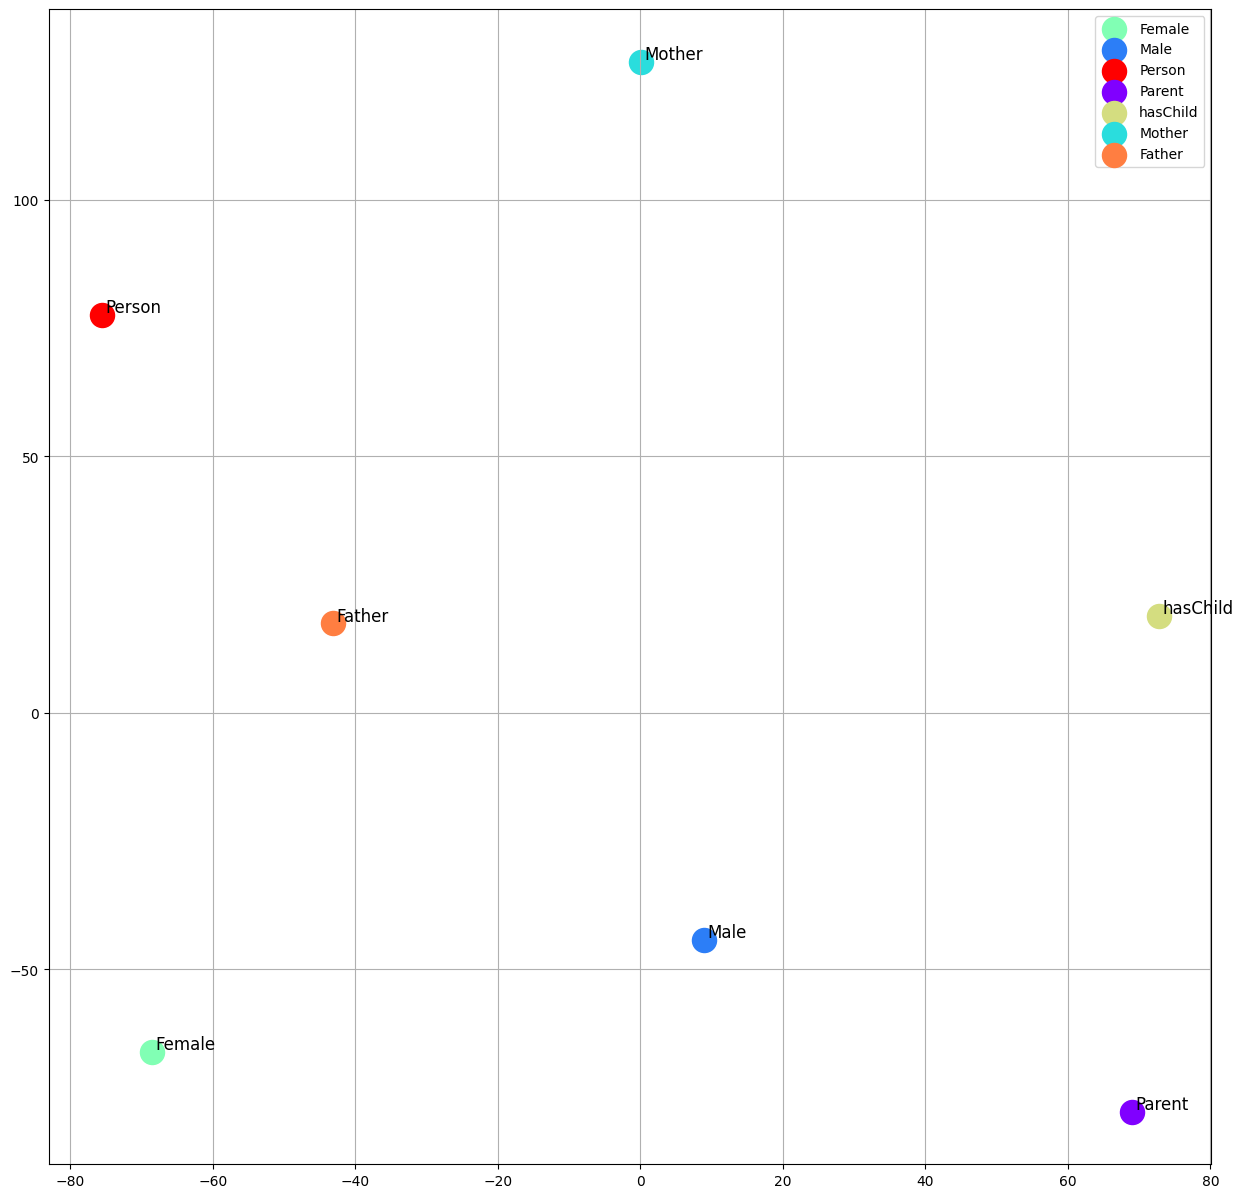

In [8]:
tsne.show(thickness=300)

## Data augmentation via reasoning

We can generate more axioms by performing reasoning over the current ontology. mOWL provides access to ELK and Hermit reasoners. Those reasoners can be accessed using the OWLAPI directly or using the `MOWLReasoner` wrapper class that provides some shortcuts to reasoner methods.

In [9]:
from mowl.reasoning.base import MOWLReasoner
from org.semanticweb.HermiT import Reasoner

reasoner = Reasoner.ReasonerFactory().createReasoner(dataset.ontology)
reasoner.precomputeInferences()

mowl_reasoner = MOWLReasoner(reasoner)
classes_to_infer_over = list(dataset.ontology.getClassesInSignature())

subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes_to_infer_over)
equivalence_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes_to_infer_over)
disjointness_axioms = mowl_reasoner.infer_disjoint_class_axioms(classes_to_infer_over)

INFO:root:Number of inferred axioms: 12.
INFO:root:Number of inferred axioms: 6.
INFO:root:Number of inferred axioms: 6.


Once the axioms were generated, it is time to add them to the ontology:

In [10]:
from mowl.owlapi import OWLAPIAdapter

manager = OWLAPIAdapter().owl_manager

for ax in subclass_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in equivalence_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in disjointness_axioms:
    manager.addAxiom(dataset.ontology, ax)

Then we can do the embedding process with the updated ontology:

In [11]:
corpus = extract_axiom_corpus(dataset.ontology)
print(f"The inferred ontology contains {len(corpus)} axioms")

INFO:root:Generating axioms corpus


The inferred ontology contains 44 axioms


In [12]:
sentences = [str(s).split(" ") for s in corpus]
sentences = [[w.replace(",", "") for w in s] for s in sentences]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 18 word types from a corpus of 185 raw words and 44 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 18 unique words (100.00% of original 18, drops 0)', 'datetime': '2023-02-04T23:53:55.591183', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 185 word corpus (100.00% of original 185, drops 0)', 'datetime': '2023-02-04T23:53:55.591570', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prep

INFO:gensim.models.word2vec:EPOCH 49: training on 185 raw words (30 effective words) took 0.0s, 200752 effective words/s
INFO:gensim.models.word2vec:EPOCH 50: training on 185 raw words (24 effective words) took 0.0s, 114982 effective words/s
INFO:gensim.models.word2vec:EPOCH 51: training on 185 raw words (27 effective words) took 0.0s, 83116 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 185 raw words (25 effective words) took 0.0s, 80812 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 185 raw words (20 effective words) took 0.0s, 53339 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 185 raw words (30 effective words) took 0.0s, 80482 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 185 raw words (30 effective words) took 0.0s, 139263 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 185 raw words (27 effective words) took 0.0s, 99691 effective words/s
INFO:gensim.models.word2vec:EPOCH 57:

INFO:gensim.models.word2vec:EPOCH 117: training on 185 raw words (31 effective words) took 0.0s, 138051 effective words/s
INFO:gensim.models.word2vec:EPOCH 118: training on 185 raw words (30 effective words) took 0.0s, 95445 effective words/s
INFO:gensim.models.word2vec:EPOCH 119: training on 185 raw words (26 effective words) took 0.0s, 117171 effective words/s
INFO:gensim.models.word2vec:EPOCH 120: training on 185 raw words (20 effective words) took 0.0s, 51932 effective words/s
INFO:gensim.models.word2vec:EPOCH 121: training on 185 raw words (23 effective words) took 0.0s, 95808 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 185 raw words (29 effective words) took 0.0s, 121683 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 185 raw words (30 effective words) took 0.0s, 149076 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 185 raw words (24 effective words) took 0.0s, 108381 effective words/s
INFO:gensim.models.word2vec

INFO:gensim.models.word2vec:EPOCH 185: training on 185 raw words (26 effective words) took 0.0s, 107284 effective words/s
INFO:gensim.models.word2vec:EPOCH 186: training on 185 raw words (28 effective words) took 0.0s, 125990 effective words/s
INFO:gensim.models.word2vec:EPOCH 187: training on 185 raw words (26 effective words) took 0.0s, 101949 effective words/s
INFO:gensim.models.word2vec:EPOCH 188: training on 185 raw words (24 effective words) took 0.0s, 100376 effective words/s
INFO:gensim.models.word2vec:EPOCH 189: training on 185 raw words (23 effective words) took 0.0s, 88173 effective words/s
INFO:gensim.models.word2vec:EPOCH 190: training on 185 raw words (29 effective words) took 0.0s, 114644 effective words/s
INFO:gensim.models.word2vec:EPOCH 191: training on 185 raw words (28 effective words) took 0.0s, 89851 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 185 raw words (39 effective words) took 0.0s, 151672 effective words/s
INFO:gensim.models.word2ve

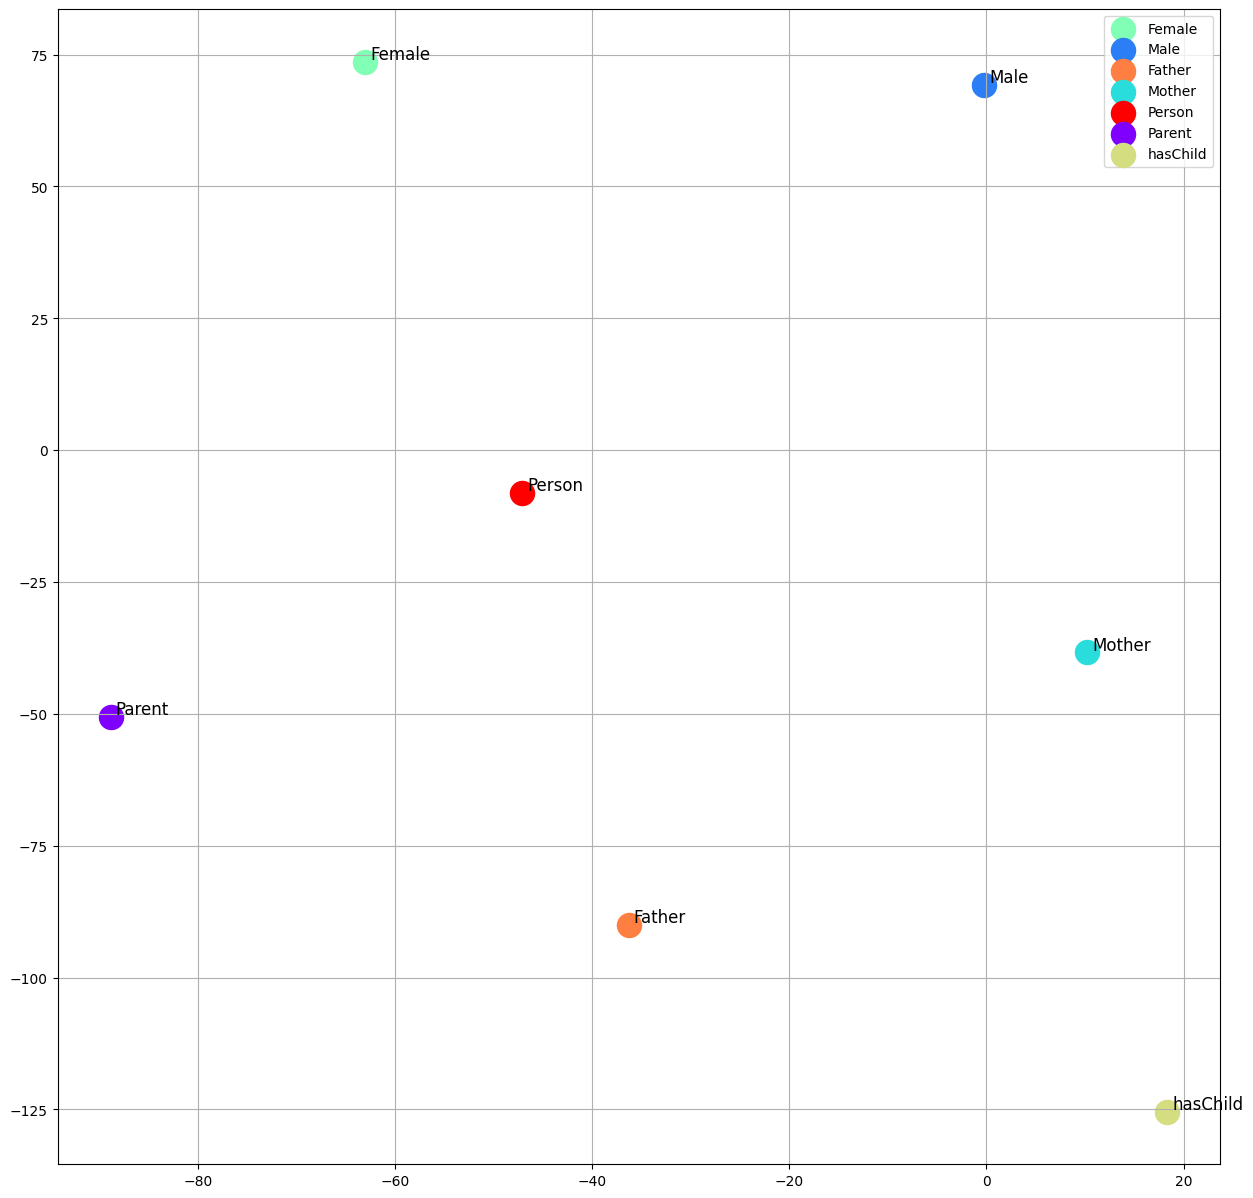

In [13]:
tsne.show(thickness=300)